# Imports & Config

In [3]:
import os, shutil, argparse, random, pickle, cv2, fnmatch, PIL, math, signal
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime

%matplotlib inline

print('[INFO] Imports done.  Using Tensorflow version: {}, and Keras version: {}'.format(tf.__version__, k.__version__))

[INFO] Imports done.  Using Tensorflow version: 1.13.1, and Keras version: 2.2.4-tf


In [4]:
config={}

config['do_dataprep'] = False

config['source'] = os.path.join(os.getcwd(), 'source_data')
config['home_dir'] = os.path.join(os.getcwd(), 'data_binary_split')

config['train_dir'] = os.path.join(os.getcwd(), 'data_binary_split', 'train')
config['test_dir'] = os.path.join(os.getcwd(), 'data_binary_split', 'test')
config['val_dir'] = os.path.join(os.getcwd(), 'data_binary_split', 'validation')

config['train_pain'] = os.path.join(config['train_dir'], 'pain')
config['train_nopain'] = os.path.join(config['train_dir'], 'nopain')
config['test_pain'] = os.path.join(config['test_dir'], 'pain')
config['test_nopain'] = os.path.join(config['test_dir'], 'nopain')
config['val_pain'] = os.path.join(config['val_dir'], 'pain')
config['val_nopain'] = os.path.join(config['val_dir'], 'nopain')

config['val_split'] = 0.1
config['test_split'] = 0.1

config['target_size'] = (320, 240)

config['train_batch'] = 100
config['test_batch'] = 100
config['val_batch'] = 100

config['epochs'] = 3

config['set_limit'] = True
config['limit'] = 1200

# Data Prep

## Split Helper Function

In [5]:
def split(SOURCE, TRAINING, TESTING, VALIDATION):
    
    print('[INFO] In Splitting')

    files = []
    
    for file in os.listdir(SOURCE): 
        files.append(file)
    
    # since the limit is less than the # of images, I will just hardcode it.  

    training_length = int(len(files) * (1-config['val_split']-config['test_split']))
    testing_length = int(len(files) * config['test_split'])
    validation_length = int(len(files) * config['val_split'])

    shuffled_set = random.sample(files, len(files))

    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:training_length+testing_length]
    validation_set = shuffled_set[training_length+testing_length:]

#     print('[INFO] Creating Training Set')
    for filename in tqdm(training_set):
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        shutil.copyfile(this_file, destination)

#     print('[INFO] Creating Testing Set')
    for filename in tqdm(testing_set):
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        shutil.copyfile(this_file, destination)

#     print('[INFO] Creating Validation Set')
    for filename in tqdm(validation_set):
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(VALIDATION, filename)
        shutil.copyfile(this_file, destination)

## Creating Directories

Strategy is to use the data in 0.0 labeled as no pain and all others as pain

In [6]:
# Create the new dirctories

new_dirs = [
    config['home_dir']
    , config['train_dir'], config['test_dir'], config['val_dir']
    , config['train_pain'], config['train_nopain']
    , config['test_pain'], config['test_nopain']
    , config['val_pain'], config['val_nopain']
           ]

if config['do_dataprep']: 
    if os.path.exists(config['home_dir']):
        shutil.rmtree(config['home_dir'])
        
    for value in new_dirs: 
        if not os.path.exists(value):
            os.mkdir(value)
    pain_data_location = os.path.join(config['source'], '0.0')

    print('[INFO] Files in pain origin dir: \t{}'.format(len(os.listdir(pain_data_location))))
    print('[INFO] Files in pain train dir: \t{}'.format(len(os.listdir(config['train_pain']))))
    print('[INFO] Files in pain test dir: \t\t{}'.format(len(os.listdir(config['test_pain']))))
    print('[INFO] Files in pain val dir: \t\t{}'.format(len(os.listdir(config['val_pain']))))
    
    split(
        SOURCE = pain_data_location
        , TRAINING = config['train_pain'] 
        , TESTING = config['test_pain'] 
        , VALIDATION = config['val_pain'] 
    )

    print('[INFO] Files in pain origin dir: \t{}'.format(len(os.listdir(pain_data_location))))
    print('[INFO] Files in pain train dir: \t{}'.format(len(os.listdir(config['train_pain']))))
    print('[INFO] Files in pain test dir: \t\t{}'.format(len(os.listdir(config['test_pain']))))
    print('[INFO] Files in pain val dir: \t\t{}'.format(len(os.listdir(config['val_pain']))))
    
    print('[INFO] Files in nopain train dir: \t{}'.format(len(os.listdir(config['train_nopain']))))
    print('[INFO] Files in nopain test dir: \t{}'.format(len(os.listdir(config['test_nopain']))))
    print('[INFO] Files in nopain val dir: \t{}'.format(len(os.listdir(config['val_nopain']))))
    
    nopain_folders = os.listdir(config['source'])
    nopain_folders.remove('0.0')
    
    for folder in nopain_folders:
        split(
            SOURCE = os.path.join(config['source'], folder)
            , TRAINING = config['train_nopain'] 
            , TESTING = config['test_nopain'] 
            , VALIDATION = config['val_nopain'] 
        )

    print('[INFO] Files in pain train dir: \t{}'.format(len(os.listdir(config['train_pain']))))
    print('[INFO] Files in pain test dir: \t\t{}'.format(len(os.listdir(config['test_pain']))))
    print('[INFO] Files in pain val dir: \t\t{}'.format(len(os.listdir(config['val_pain']))))

In [7]:
limiting_dirs = [
        config['train_pain'], config['train_nopain']
        , config['test_pain'], config['test_nopain']
        , config['val_pain'], config['val_nopain']
    ]

if config['do_dataprep']: 

    print('Before')
    for d in limiting_dirs: 
        print('{}: {}'.format(d, len(os.listdir(d))))

    print('\nAfter')
    for d in limiting_dirs: 
        counter = 1
        for filename in os.listdir(d): 
            if counter > config['limit']:
                os.remove(os.path.join(d, filename))
            counter = counter +1

for d in limiting_dirs: 
    print('{}: {}'.format(d, len(os.listdir(d))))

/data/home/maj/notebooks/w210-final-project/MAJ/data_binary_split/train/pain: 1200
/data/home/maj/notebooks/w210-final-project/MAJ/data_binary_split/train/nopain: 1200
/data/home/maj/notebooks/w210-final-project/MAJ/data_binary_split/test/pain: 1200
/data/home/maj/notebooks/w210-final-project/MAJ/data_binary_split/test/nopain: 831
/data/home/maj/notebooks/w210-final-project/MAJ/data_binary_split/validation/pain: 1200
/data/home/maj/notebooks/w210-final-project/MAJ/data_binary_split/validation/nopain: 850


#  Modelling

## Helper Functions

In [8]:
def create_and_compile_model(): 
    model = k.models.Sequential([
        k.layers.Conv2D(16, (3,3), activation='relu', input_shape=(*config['target_size'], 3),  name='mh-conv-1')
        , k.layers.MaxPooling2D(2, 2, name='mh-maxpool-1')
        , k.layers.Conv2D(32, (3,3), activation='relu', name='mh-conv-2')
        , k.layers.MaxPooling2D(2,2, name='mh-maxpool-2')
        , k.layers.Conv2D(64, (3,3), activation='relu', name='mh-conv-3')
        , k.layers.MaxPooling2D(2,2, name='mh-maxpool-3')
        , k.layers.Conv2D(128, (3,3), activation='relu', name='mh-conv-4')
        , k.layers.MaxPooling2D(2,2, name='mh-maxpool-4')
        , k.layers.Conv2D(256, (3,3), activation='relu', name='mh-conv-5')
        , k.layers.MaxPooling2D(2,2, name='mh-maxpool-5')
        , k.layers.Flatten(name='mh-flatten-1')
        , k.layers.Dense(1024, activation='relu', name='mh-dense-1')
        , k.layers.Dropout(0.2)
        , k.layers.Dense(128, activation='relu', name='mh-dense-2')
        , k.layers.Dropout(0.2)
        , k.layers.Dense(1, activation='sigmoid', name='mh-dense-output')
    ])
    
    model.compile(
        optimizer=Adam()
        , loss='binary_crossentropy'
        , metrics=['binary_accuracy']
    )
    
    return model

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('binary_accuracy')>0.99):
            print('\nReached 99% accuracy which is satisfactory so stopped training!')
            self.model.stop_training = True
        if(logs.get('binary_accuracy')<0.4):
            print('\nUnable to go over 40% accuracy, so cancelling run!')
            self.model.stop_training = True

markscallbacks = myCallback()

## Image Generators

In [10]:
config['train_count'] = sum([len(files) for r, d, files in os.walk(config['train_dir'])])
config['train_steps'] = math.ceil(config['train_count']/config['train_batch'])

train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    config['train_dir']
    , target_size = config['target_size'] 
    , batch_size = config['train_batch']
    , class_mode = 'binary'
)

Found 2400 images belonging to 2 classes.


In [11]:
config['val_count'] = sum([len(files) for r, d, files in os.walk(config['val_dir'])])
config['val_steps'] = math.ceil(config['val_count']/config['val_batch'])

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    config['val_dir']  # This is the source directory for training images
    , target_size = config['target_size']  # All images will be resized to 150x150 for compressing
    , batch_size = config['val_batch']
    , class_mode = 'binary' # Since we use binary_crossentropy loss, we need binary labels
)

Found 2050 images belonging to 2 classes.


In [12]:
config['test_count'] = sum([len(files) for r, d, files in os.walk(config['test_dir'])])
config['test_steps'] = math.ceil(config['test_count']/config['test_batch'])

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    config['test_dir']  # This is the source directory for training images
    , target_size = config['target_size']  # All images will be resized to 150x150 for compressing
    , batch_size = config['test_batch']
    , class_mode = 'binary' # Since we use binary_crossentropy loss, we need binary labels
)

Found 2031 images belonging to 2 classes.


## Training

In [13]:
model = create_and_compile_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mh-conv-1 (Conv2D)           (None, 318, 238, 16)      448       
_________________________________________________________________
mh-maxpool-1 (MaxPooling2D)  (None, 159, 119, 16)      0         
_________________________________________________________________
mh-conv-2 (Conv2D)           (None, 157, 117, 32)      4640      
_________________________________________________________________
mh-maxpool-2 (MaxPooling2D)  (None, 78, 58, 32)        0         
_________________________________________________________________
mh-conv-3 (Conv2D)           (None, 76, 56, 64)        18496     
_________________________________________________________________
mh-maxpool-3 (MaxPool

In [15]:
new_directory = os.path.join(os.getcwd(), 'marks-runs', '{}'.format(datetime.datetime.now().strftime("%Y%m%d%H%M")))
if os.path.exists(new_directory):
        shutil.rmtree(new_directory)

os.mkdir(new_directory)

history = model.fit_generator(
    train_generator
    , steps_per_epoch = config['train_steps']
    , epochs = config['epochs']
    , validation_data = val_generator
    , validation_steps = config['val_steps']
    , callbacks=[
        markscallbacks
        , EarlyStopping(monitor='val_binary_accuracy', patience=3)
        , ModelCheckpoint(filepath=os.path.join(new_directory, 'model.h5'), monitor='acc', save_best_only=True)
        , ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    ]
)

print('\n[INFO] Training Complete')

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
24/24 [==============================] - 18s 768ms/step - loss: 0.6956 - acc: 0.5042 - binary_accuracy: 0.5042 - val_loss: 0.6928 - val_acc: 0.5156 - val_binary_accuracy: 0.5156
Epoch 2/50
24/24 [==============================] - 15s 641ms/step - loss: 0.6808 - acc: 0.5621 - binary_accuracy: 0.5621 - val_loss: 0.6425 - val_acc: 0.6556 - val_binary_accuracy: 0.6556
Epoch 3/50
24/24 [==============================] - 15s 639ms/step - loss: 0.6384 - acc: 0.6350 - binary_accuracy: 0.6350 - val_loss: 0.6181 - val_acc: 0.6678 - val_binary_accuracy: 0.6678
Epoch 4/50
24/24 [==============================] - 15s 643ms/step - loss: 0.5735 - acc: 0.7121 - binary_accuracy: 0.7121 - val_loss: 0.5459 - val_acc: 0.7229 - val_binary_accuracy: 0.7229
Epoch 5/50
24/24 [==============================] - 15s 637ms/step - loss: 0.5097 - acc: 0.7629 - binary_accuracy: 0.7629 - val_loss: 0.5300 - val_acc: 0.7395 - val_binary_accuracy: 0.7395
Epoch 6

In [16]:
predicted = model.predict_generator(test_generator, steps=config['test_steps'])
labels = test_generator.classes

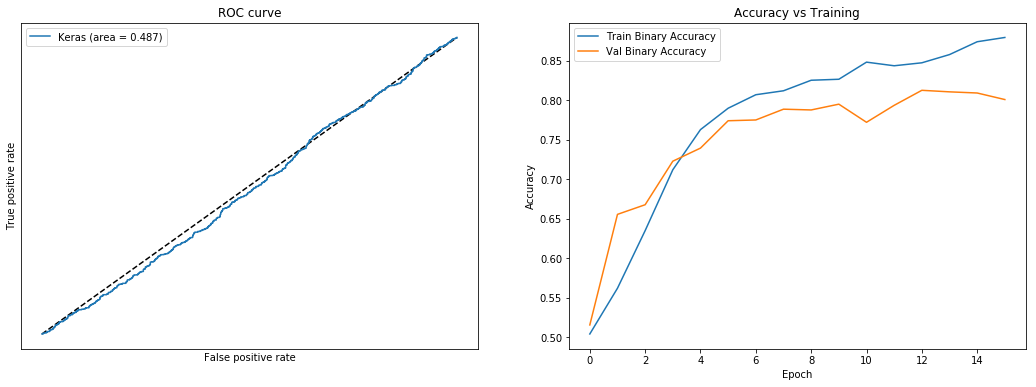

In [20]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, predicted)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(18,6))

plt.subplot(1, 2 ,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
# plt.show()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist['epoch'], hist['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(hist['epoch'], hist['val_binary_accuracy'], label = 'Val Binary Accuracy')
plt.title('Accuracy vs Training')
plt.legend(loc='best')

# plt.show()

plt.savefig(os.path.join(new_directory, 'result plots.png'))

hist.to_csv(os.path.join(new_directory, 'run_results.csv'))

```python 
res_dict = {
    'epochs' : config['epochs']
    , 'accuracy' : history.history['acc']
    , 'val_accuracy' : history.history['val_acc']
    , 'loss' : history.history['loss']
    , 'val_loss' : history.history['val_loss']
}

df = pd.DataFrame(res_dict)
os.mkdir(os.path.join(os.getcwd(), 'trial01'))
df.to_csv(os.path.join(os.getcwd(), 'trial01', '01 - results.csv'))

model.save(os.path.join(os.getcwd(), 'trial01', 'model.h5'))
```

In [ ]:
# Next step, custom metrics
# Look at random images in both directories
# Rethink the Split 0.0 vs 1.0-14.0

In [ ]:
print('Completed running Notebook')

In [ ]:
os.kill(os.getpid(), signal.SIGKILL)